# Simple Linear Model

### Giới thiệu

Bài này sẽ sử dụng Tensorflow để mô tả một cách đơn giản về mô hình của hàm tuyến tính. 

Dữ liệu đầu vào là tập dữ liệu số viết tay: MNIST, bao gồm 70,000 ảnh đã được gắn nhãn tương ứng và được chia làm 3 phần:
- Train-set: 55,000
- Test-set : 10,000
- Validation: 5,000

Thuật toán sử dụng sẽ giải quyết bài toán Phân lớp (Classification) trong Machine Learning.


In [1]:
# Import library
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math

In [2]:
# Load data <MNIST>
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### One-hot Encoding

Tập dữ liệu được load ở trên còn được gọi là One-hot encoding. Nghĩa là các nhãn đã được chuyển từ chữ số sang vector với độ dài của vector bằng số class của mô hình phân lớp.

In [3]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

Ở trên là cách biểu diễn các nhãn và lưu ở dạng vector. Đối với bài toán này, ta cần phân lớp thành các số từ 0 - 9, do đó, ta sẽ convert các label này sang 10 class như sau:

In [16]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimension
Ta note lại các thông số của ảnh đầu vào, bao gồm: kích thước ảnh, số chiều, số class sẽ phân loại.


In [4]:
img_size = int(math.sqrt(len(data.test.images[1])))
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

### Function to plot images

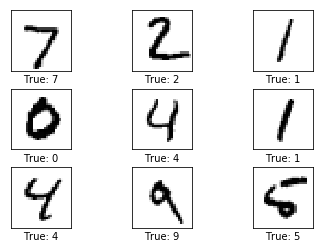

In [18]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images = images, cls_true = cls_true)

### Tensorflow Graph

Điểm đặc biệt của TensorFlow là Computational Graph, thực thi tính toán hiệu quả hơn so với Numpy hay các hàm khác trong Python.



In [5]:
# placeholder variables
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.float32, [None])

In [6]:
# variables for parameters
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [7]:
# Model
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [8]:
# Cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [9]:
# optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

In [24]:
# performance measures
correct_prediction = tf.equal(y_pred_cls, tf.float32(y_true_cls))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

TypeError: 'DType' object is not callable

### Tensorflow Run

In [10]:
session = tf.Session()
session.run(tf.global_variables_initializer())
batch_size=16

In [11]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [17]:
feed_dict_test={x:data.test.images, 
               y_true: data.test.labels,
               y_true_cls: data.test.cls}

In [22]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [18]:
def print_confusion_matrix():
    cls_true=data.test.cls
    cls_pred=session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks= np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [19]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_image(images=images[0:9], cls_true = cls_true[0:9], cls_pred=cls_pred[0:9])

In [20]:
def plot_weights():
    w = seesion.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplot(3,4)
    fig.subplots_adjust(hspace=.3, wspace=.3)
    
    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(image_shape)
            ax.set_xlabel("Weights: {0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])

In [23]:
print_accuracy()

NameError: name 'accuracy' is not defined